In [1]:
import numpy as np
import pandas as pd
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from datetime import datetime
from datetime import timedelta


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12,10) #提前设置图片形状大小

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# # This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', False)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)
pd.set_option('display.max_columns', None)
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important; }</style>"))
import dask
import joblib
from multiprocessing import cpu_count
import functools
from collections import OrderedDict
import warnings
import hfhd.hf as hf
from itertools import product
import pickle

from utils_new import *
from RemoteQuery import *
src = RemoteSrc()

#### **Example of HY function**

In [2]:
import hfhd.hf as hf

np.random.seed(0)
n = 10000
returns = np.random.multivariate_normal([0, 0], [[1,0.5],[0.5,1]], n)/n**0.5
prices = np.exp(returns.cumsum(axis=0))
# sample n/2 (non-synchronous) observations of each tick series
series_a = pd.Series(prices[:, 0]).sample(int(n/2)).sort_index()
series_b = pd.Series(prices[:, 1]).sample(int(n/2)).sort_index()
# take logs
series_a = np.log(series_a)
series_b = np.log(series_b)
icov = hf.hayashi_yoshida([series_a, series_b])
np.round(icov, 3)

array([[0.983, 0.512],
       [0.512, 0.99 ]])

#### **Brief test for stock data**

In [ ]:
code1 = '000776'
code2 = '601162'
code3 = '601696'
begin = '2022-04-06'
end = '2022-04-29'

import tushare as ts
ts.set_token('0d86b9a1aa5a9ba78b7e3a2feba63242abaeae62c777f5742f6cf698')
pro = ts.pro_api()
# df = pro.trade_cal(exchange='', start_date=begin, end_date=end, fields='exchange,cal_date,is_open,pretrade_date', is_open='0')
df = ts.get_k_data('sh', start=begin, end=end)
df.tail()

date_list = df['date'].str.replace('-', '').to_list()

date_list = ['20220412']

def process_one_stock2(code, date):
    asset = src.get_raw_bars(code, date)
    begin_time = '09:30:00'
    end_time = '14:57:00'
    range_ = (asset['time'] >= begin_time)&(asset['time'] < end_time)
    asset = asset[range_]
    asset['midquote'] = (asset['ask_price1'] + asset['bid_price1'])/2
    asset['delta_quote'] = asset['midquote'].diff()
    # asset = asset[(asset['delta_quote'] != 0)]
    return asset


asset1 = list(map(lambda date: process_one_stock2(code1, date), date_list))
asset_combined1 = pd.concat(asset1, ignore_index=True)
asset_combined1.sort_values(by=['server_time'], ascending=True, inplace=True)
asset2 = list(map(lambda date: process_one_stock2(code2, date), date_list))
asset_combined2 = pd.concat(asset2, ignore_index=True)
asset_combined2.sort_values(by=['server_time'], ascending=True, inplace=True)
asset3 = list(map(lambda date: process_one_stock2(code3, date), date_list))
asset_combined3 = pd.concat(asset3, ignore_index=True)
asset_combined3.sort_values(by=['server_time'], ascending=True, inplace=True)

In [88]:
a = hf.hayashi_yoshida([asset_combined1.set_index('server_time')['midquote'], asset_combined2.set_index('server_time')['midquote'], asset_combined3.set_index('server_time')['midquote']])
a

array([[ 3.1075000e-01,  3.9000000e-03, -5.4075000e-02],
       [ 3.9000000e-03,  1.3900000e-02,  1.6250000e-03],
       [-5.4075000e-02,  1.6250000e-03,  5.2972325e+01]])

In [82]:
a = hf.hayashi_yoshida([asset_combined1.set_index('server_time')['midquote'], asset_combined2.set_index('server_time')['midquote'], asset_combined3.set_index('server_time')['midquote']])
a

array([[ 6.06050000e-01,  7.40000000e-03, -1.85625000e+00],
       [ 7.40000000e-03,  2.49750000e-02, -1.36950000e-01],
       [-1.85625000e+00, -1.36950000e-01,  3.53922475e+02]])

In [73]:
hf.hayashi_yoshida([asset_combined1['midquote'][asset_combined1['delta_quote'].notnull()], asset_combined2['midquote'][asset_combined2['delta_quote'].notnull()]])


array([[0.60605 , 0.001675],
       [0.001675, 0.024975]])

In [42]:
np.sqrt(np.diag(a))

array([0.55744955, 0.11789826])

In [89]:
d = np.diag(np.sqrt(np.diag(a)))
d_inv = np.linalg.inv(d)
d_inv @ a @ d_inv

array([[ 1.        ,  0.05934056, -0.01332804],
       [ 0.05934056,  1.        ,  0.00189374],
       [-0.01332804,  0.00189374,  1.        ]])

In [59]:
0.0006/(np.sqrt((asset_combined1['delta_quote']**2).sum() * (asset_combined2['delta_quote']**2).sum()))

0.0118946984489069

In [90]:
asset_combined1[asset_combined1['delta_quote'].isnull()]

,date,code,server_time,local_time,preclose,open,high,low,last,upper_limit,lower_limit,volume,turnover,iopv,ask_price1,ask_volume1,ask_price2,ask_volume2,ask_price3,ask_volume3,ask_price4,ask_volume4,ask_price5,ask_volume5,ask_price6,ask_volume6,ask_price7,ask_volume7,ask_price8,ask_volume8,ask_price9,ask_volume9,ask_price10,ask_volume10,bid_price1,bid_volume1,bid_price2,bid_volume2,bid_price3,bid_volume3,bid_price4,bid_volume4,bid_price5,bid_volume5,bid_price6,bid_volume6,bid_price7,bid_volume7,bid_price8,bid_volume8,bid_price9,bid_volume9,bid_price10,bid_volume10,time,midquote,delta_quote
0,20220412,000776.SZSE,2022-04-12 09:30:00,2022-04-12 09:30:00.000,16.98,16.85,16.93,16.85,16.86,18.68,15.28,253900,4279847,0,16.89,2300,16.92,400,16.93,900,16.95,6700,16.97,2500,16.98,15300,16.99,4300,17.0,24200,17.01,100,17.02,2500,16.86,8100,16.85,74500,16.84,45600,16.83,39400,16.82,73000,16.81,46500,16.8,44800,16.78,21200,16.77,2600,16.76,2400,09:30:00,16.875,NaN


In [94]:
asset_combined1['prev_time'] = asset_combined1['server_time'].shift()
asset_combined2['prev_time'] = asset_combined2['server_time'].shift()
asset_combined3['prev_time'] = asset_combined3['server_time'].shift()

asset_combined1 = asset_combined1[asset_combined1['delta_quote'].notnull()]
asset_combined2 = asset_combined2[asset_combined2['delta_quote'].notnull()]
asset_combined3 = asset_combined3[asset_combined3['delta_quote'].notnull()]

In [95]:
hy_corr(asset_combined1, asset_combined3, timedelta(seconds=0), 'lead')

-0.013328044742553587

In [96]:
hy_corr(asset_combined2, asset_combined3, timedelta(seconds=0), 'lead')

0.0018937447756195438

#### **Debug and Whole trial on the stock data**

In [2]:
begin = '2022-04-06'
end = '2022-04-29'

import tushare as ts
ts.set_token('0d86b9a1aa5a9ba78b7e3a2feba63242abaeae62c777f5742f6cf698')
pro = ts.pro_api()
# df = pro.trade_cal(exchange='', start_date=begin, end_date=end, fields='exchange,cal_date,is_open,pretrade_date', is_open='0')
df = ts.get_k_data('sh', start=begin, end=end)

date_list = df['date'].str.replace('-', '').to_list()
date_list = ['20220412', '20220413']
code_list2 = pd.read_csv("./data/hushen300.csv")
code_list2 = code_list2['代码'].apply(lambda x: "%06d"%x)
code_list2 = code_list2.tolist()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [4]:
nums = [1, 2, 4, 8, 10, 15, 20, 30, 40, 50, 60, 120, 180, 240, 300]
grid = [timedelta(seconds=i) for i in nums]
nums.__len__()

15

In [16]:
res = prepare_all_data(code_list2, date_list)
res

[            code  midquote         server_time  delta_quote
 0     000001.SSE  8.060063 2022-04-12 09:30:04          NaN
 1     000001.SSE  8.060502 2022-04-12 09:30:09     0.000439
 2     000001.SSE  8.061244 2022-04-12 09:30:14     0.000742
 3     000001.SSE  8.062389 2022-04-12 09:30:19     0.001145
 4     000001.SSE  8.062530 2022-04-12 09:30:24     0.000142
 ...          ...       ...                 ...          ...
 3076  000001.SSE  8.074478 2022-04-12 14:56:44    -0.000072
 3077  000001.SSE  8.074478 2022-04-12 14:56:46     0.000000
 3078  000001.SSE  8.074568 2022-04-12 14:56:49     0.000090
 3079  000001.SSE  8.074356 2022-04-12 14:56:54    -0.000212
 3080  000001.SSE  8.074391 2022-04-12 14:56:59     0.000034
 
 [3081 rows x 4 columns],
              code  midquote         server_time  delta_quote
 0     000002.SZSE  3.042139 2022-04-12 09:30:00          NaN
 1     000002.SZSE  3.036634 2022-04-12 09:30:03    -0.005504
 2     000002.SZSE  3.039031 2022-04-12 09:30:06     0

In [ ]:
p = 3
idx = np.array([[0, i] for i in range(p)] + [[i, i] for i in range(1, p)], dtype=np.int16)

In [5]:
%%time
test = hf.hayashi_yoshida(res, how='only')
test

CPU times: user 14min 52s, sys: 3.42 s, total: 14min 56s
Wall time: 19 s


array([[0.02145172, 0.00046994, 0.00038371, ..., 0.00157557, 0.0018077 ,
        0.00118634],
       [0.00046994, 0.01222457, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00038371, 0.        , 0.02181422, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00157557, 0.        , 0.        , ..., 0.01099934, 0.        ,
        0.        ],
       [0.0018077 , 0.        , 0.        , ..., 0.        , 0.01883547,
        0.        ],
       [0.00118634, 0.        , 0.        , ..., 0.        , 0.        ,
        0.0216417 ]])

In [7]:
a = test[0, :]
b = np.diag(test)
len(a)

300

In [14]:
len(b)

300

In [17]:
a[1]/b[1]

0.1631942952885942

In [8]:
a[np.isnan(a)]

array([nan, nan, nan])

In [24]:
res[80]

server_time
2022-04-06 09:30:00    3.913522
2022-04-06 09:30:03    3.913522
2022-04-06 09:30:06    3.913122
2022-04-06 09:30:09    3.914320
2022-04-06 09:30:11    3.913122
                         ...   
2022-04-29 14:56:45    3.899343
2022-04-29 14:56:48    3.899545
2022-04-29 14:56:51    3.899545
2022-04-29 14:56:54    3.899545
2022-04-29 14:56:57    3.899647
Name: midquote, Length: 80799, dtype: float64

In [21]:
np.where(np.isnan(a))

(array([ 80, 178, 206]),)

In [14]:
a = np.array([[0,0], [2,2]])
a[0][1]

0

In [12]:
hf.hayashi_yoshida(res[:3], choice='cov')

array([[1.92154119e-02, 1.75324106e-03, 2.62786447e-03],
       [1.75324106e-03, 1.10701556e-02, 1.87585414e-03],
       [2.62786447e-03, 1.87585414e-03, 9.82776693e+00]])

In [13]:
hf.hayashi_yoshida_simplified(res[:10], choice='pairwise')

array([ 0.01921541,  0.00175324,  0.00262786,  0.00169299, -0.00039422,
        0.00138536,  0.00225958,  0.00038701,  0.00191857,  0.0012253 ])

In [7]:
a = hf.hayashi_yoshida_simplified(res, choice='pairwise')
b = hf.hayashi_yoshida_simplified(res, choice='own')
a/np.sqrt(b)/np.sqrt(b[0])

array([ 1.00000000e+00,  1.20209813e-01,  6.04714929e-03,  1.30292155e-01,
       -2.83378197e-03,  1.01576388e-01,  1.20182497e-01,  2.97406589e-02,
        1.03734315e-01,  6.21319331e-02,  1.07350849e-01,  1.13613906e-01,
        6.15529133e-02,  6.80589614e-02,  9.58875783e-03,  6.08838862e-02,
        5.24022405e-02, -4.70925134e-03,  4.58225656e-02,  1.05813983e-01,
        1.02626245e-01,  3.80793468e-02,  1.21145779e-01,  1.28939880e-01,
        5.65466196e-02,  8.31127033e-02,  3.21542477e-02,  1.82604961e-02,
        1.24526263e-01,  9.32024136e-02, -7.33218513e-03,  4.20770607e-02,
        6.33450874e-02,  1.77929495e-01,  6.11783202e-02,  1.55950065e-01,
        1.02818740e-01,  7.87237742e-02,  1.16404343e-01,  9.89890597e-02,
        6.01584662e-02,  9.30957408e-02,  1.01856307e-01,  1.11162476e-01,
        5.69550337e-02,  7.04985160e-02,  1.43194567e-01,  2.37996432e-03,
        5.62941507e-02,  1.04408632e-02,  3.18279998e-02,  6.77117969e-02,
        7.71290101e-02,  

In [18]:
a/np.sqrt(b)/np.sqrt(a[0])

array([ 1.00000000e+00,  1.35668531e-01,  1.63758276e-01,  1.12457044e-01,
        1.26093472e-01,  2.30432262e-02,  1.30012966e-01,  2.97583913e-01,
        1.33765112e-01,  1.59996342e-01,  9.43534921e-02, -5.00168641e-02,
        1.71896058e-01, -2.70924091e-03,  6.81163194e-02,  9.13782580e-02,
        1.25730492e-01,  6.33231768e-03,  7.07595141e-02,  5.72596208e-03,
        1.35153505e-01,  1.07605123e-01,  1.43689392e-01,  1.24102797e-01,
        1.43066246e-01,  6.00876870e-03,  9.80305366e-02,  1.54955328e-01,
       -5.21305507e-02,  8.56982368e-02,  1.31351203e-01,  7.63398226e-02,
        1.03299774e-02,  8.76827863e-02, -2.42750251e-02, -9.10428062e-03,
        8.23928380e-02,  4.97042065e-02,  7.70455830e-02,  1.86533166e-01,
        1.93607764e-02,  1.12419434e-01,  1.64357706e-01,  4.06874674e-02,
        6.42490468e-02,  9.98910439e-03,  9.56493350e-02,  4.31069176e-03,
        1.18128797e-01, -3.50345398e-02,  1.10646934e-01,  5.42883365e-02,
        1.79656414e-02,  

In [7]:
d = np.diag(np.sqrt(np.diag(test)))
d_inv = np.linalg.inv(d)
d_inv @ test @ d_inv

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [14]:
idx = np.array([[i, i] for i in range(4)], dtype=np.int16)
idx

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3]], dtype=int16)

In [18]:
i, j = idx[3, :]
i
j

3

In [10]:
p = 4
idx = np.array([[0, i] for i in range(p)] + [[i, i] for i in range(1, p)], dtype=np.int16)
idx

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 1],
       [2, 2],
       [3, 3]], dtype=int16)

In [9]:
from numba import prange
for t in prange(len(idx)):
    print(idx[t, :])

[0 0]
[0 1]
[0 2]
[0 3]
[1 1]
[2 2]
[3 3]


In [7]:
def upper_triangular_indeces(p):
    """Get the upper triangular indeces of a square matrix. int16 should
    suffice for even the largest ``p`` encountered in practice.

    Parameters
    ----------
    p : int
        The dimension of the square matrix.

    Returns
    -------
    idx : numpy.ndarray, shape(int((p*(p+1)/2), 2)
        The array of indeces. i in zeroth column, j in first column.
    """
    s = 0
    idx = np.zeros((int((p*(p+1)/2)), 2), dtype=np.int16)
    for i in range(p):
        for j in range(i, p):
            idx[s] = i, j
            s += 1
    if idx[-1, 0] <= 0:
        raise ValueError("Got negative index, ``p`` probably too large for int16")
    return idx

In [20]:
p = 4
cov = np.zeros((p, p))
idx = upper_triangular_indeces(p)
idx

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 2],
       [2, 3],
       [3, 3]], dtype=int16)

In [13]:
idx[1,:]

array([0, 1], dtype=int16)

#### **Trial test for stock data**

In [2]:
begin = '2022-01-04'
# end = '2022-04-29'
end = '2022-06-16'

import tushare as ts
ts.set_token('0d86b9a1aa5a9ba78b7e3a2feba63242abaeae62c777f5742f6cf698')
pro = ts.pro_api()
# df = pro.trade_cal(exchange='', start_date=begin, end_date=end, fields='exchange,cal_date,is_open,pretrade_date', is_open='0')
df = ts.get_k_data('sh', start=begin, end=end)

date_list = df['date'].str.replace('-', '').to_list()
# date_list = ['20220412', '20220413']


code_list2 = pd.read_csv("./data/hushen300.csv")
code_list2 = code_list2['代码'].apply(lambda x: "%06d"%x)
code_list2 = code_list2.tolist()

# use all stocks
# code_list2 = get_stock_list(date_list)

nums = [1, 2, 4, 8, 10, 15, 20, 30, 40, 50, 60, 120, 180, 240, 300]

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [3]:
code_list2[:10]

['000001',
 '000002',
 '000063',
 '000066',
 '000069',
 '000100',
 '000157',
 '000166',
 '000301',
 '000333']

In [4]:
list(set([1,2,3,4,5,65]).intersection(set([1,2,3,65,7])))

[65, 2, 3, 1]

In [7]:
# test whether the tick data are available in the redis
df_bytes_from_redis = SERVER.hget("tick_list", "20220106")
df_from_redis = pickle.loads(df_bytes_from_redis)
print(df_from_redis)

[server_time
2022-01-06 09:30:04    8.183487
2022-01-06 09:30:09    8.183166
2022-01-06 09:30:14    8.183263
2022-01-06 09:30:19    8.183459
2022-01-06 09:30:24    8.183657
                         ...   
2022-01-06 14:56:39    8.185197
2022-01-06 14:56:44    8.185320
2022-01-06 14:56:49    8.185161
2022-01-06 14:56:54    8.185286
2022-01-06 14:56:59    8.185088
Name: midquote, Length: 3081, dtype: float64, server_time
2022-01-06 09:30:00    3.048799
2022-01-06 09:30:03    3.049510
2022-01-06 09:30:06    3.049510
2022-01-06 09:30:09    3.049984
2022-01-06 09:30:12    3.050930
                         ...   
2022-01-06 14:56:45    3.048562
2022-01-06 14:56:48    3.048325
2022-01-06 14:56:51    3.048088
2022-01-06 14:56:54    3.048562
2022-01-06 14:56:57    3.048562
Name: midquote, Length: 4741, dtype: float64, server_time
2022-01-06 09:30:04    8.090087
2022-01-06 09:30:09    8.089574
2022-01-06 09:30:14    8.089820
2022-01-06 09:30:14    8.089820
2022-01-06 09:30:19    8.090182
       

In [6]:
%%time
all_stock_data = prepare_all_data(code_list2, date_list)

Fail to retrive the data for 000425 on 20220104
limit up/down occurs at 20220104 for stock 002371
limit up/down occurs at 20220104 for stock 002821
limit up/down occurs at 20220104 for stock 600085
limit up/down occurs at 20220104 for stock 601865
limit up/down occurs at 20220105 for stock 600018
limit up/down occurs at 20220106 for stock 601669
limit up/down occurs at 20220107 for stock 601100
limit up/down occurs at 20220112 for stock 603799
limit up/down occurs at 20220117 for stock 002001
limit up/down occurs at 20220117 for stock 603392
limit up/down occurs at 20220118 for stock 600011
limit up/down occurs at 20220118 for stock 601669
limit up/down occurs at 20220118 for stock 601800
limit up/down occurs at 20220118 for stock 605499
limit up/down occurs at 20220119 for stock 000661
limit up/down occurs at 20220119 for stock 600030
limit up/down occurs at 20220120 for stock 000661
limit up/down occurs at 20220120 for stock 600030
limit up/down occurs at 20220121 for stock 000661
li

In [ ]:
%%time
code = '000776'
target = list(map(lambda dt: process_one_stock(code, dt), date_list))
target

[server_time
 2022-05-06 09:30:00    2.725563
 2022-05-06 09:30:03    2.725235
 2022-05-06 09:30:06    2.724252
 2022-05-06 09:30:09    2.724252
 2022-05-06 09:30:12    2.721624
                          ...   
 2022-05-06 14:56:45    2.711046
 2022-05-06 14:56:48    2.711710
 2022-05-06 14:56:51    2.711710
 2022-05-06 14:56:54    2.711710
 2022-05-06 14:56:57    2.711046
 Name: midquote, Length: 4741, dtype: float64,
 server_time
 2022-05-09 09:30:00    2.703038
 2022-05-09 09:30:03    2.703373
 2022-05-09 09:30:06    2.703373
 2022-05-09 09:30:09    2.703707
 2022-05-09 09:30:12    2.703038
                          ...   
 2022-05-09 14:56:45    2.719649
 2022-05-09 14:56:48    2.719649
 2022-05-09 14:56:51    2.718990
 2022-05-09 14:56:54    2.718990
 2022-05-09 14:56:57    2.718990
 Name: midquote, Length: 4740, dtype: float64,
 server_time
 2022-05-10 09:30:00    2.704377
 2022-05-10 09:30:03    2.703038
 2022-05-10 09:30:06    2.702367
 2022-05-10 09:30:09    2.701697
 2022-05-

In [ ]:
%%time
meg_data = np.column_stack((target, all_stock_data))
meg_data = meg_data.tolist()

In [ ]:
%%time
# code_list1 = ['000776', '002142', '600030']
code_list1 = ['000776']
res = calc_all_pairs(code_list1, code_list2, date_list, nums)
res

limit up/down occurs at 20220316 for stock 000776
CPU times: user 5min 12s, sys: 2min 15s, total: 7min 28s
Wall time: 11min 23s


OrderedDict([('000776',
              (array([[ 1.00000000e+00,  7.16502715e-04,  4.55323816e-04, ...,
                       -3.02808292e-03, -4.30848248e-04,  9.69603780e-05],
                      [ 1.00000000e+00,  2.91521682e-03,  1.33088630e-03, ...,
                        2.95592115e-03, -2.09585325e-03, -2.42234949e-03],
                      [ 1.00000000e+00,  4.19708110e-04,  2.51680449e-03, ...,
                        1.31530913e-03, -1.39736146e-04, -4.15025080e-05],
                      ...,
                      [ 1.00000000e+00,  5.73858715e-03,  2.38155172e-03, ...,
                        6.48503029e-04,  2.73299806e-03,  1.75707570e-03],
                      [ 1.00000000e+00,  4.33687866e-03,  5.13865882e-03, ...,
                        3.35145579e-03,  2.21614831e-04,  5.09484335e-03],
                      [ 1.00000000e+00,  5.43573000e-03,  2.96055838e-03, ...,
                        2.92186303e-03,  5.53831203e-03,  1.58610514e-03]]),
               array([[

In [ ]:
with open("./data/000776_fast.pkl", "wb") as tf:
    pickle.dump(res, tf) 

In [ ]:
with open("./data/000776_fast.pkl", "rb") as tf:
    res = pickle.load(tf)

In [ ]:
result, result_std = res['000776']
result.shape
result_std.shape

(31, 301)

(31, 301)

In [ ]:
np.logspace(-1.5, 1, num=10, base=2)

array([0.35355339, 0.42862199, 0.51962961, 0.62996052, 0.76371757,
       0.92587471, 1.12246205, 1.36079   , 1.64972119, 2.        ])

In [ ]:
res_left, res_right = result-1.96*result_std/np.sqrt(date_list.__len__()), result+1.96*result_std/np.sqrt(date_list.__len__())

In [ ]:
# In total how many stocks have limit up/down during this WHOLE period
result[np.isnan(result)].shape[0]/(2*nums.__len__()+1)

0.0

In [ ]:
hushen300 = pd.read_csv("./data/hushen300.csv")
whole_nums = list(map(lambda x: -x, nums))[::-1] + [0] + nums

In [ ]:
temp = pd.DataFrame(result, columns=['广发证券'] + hushen300['名称'].tolist(), index=whole_nums)
temp_left = pd.DataFrame(res_left, columns=['广发证券'] + hushen300['名称'].tolist(), index=whole_nums)
temp_right = pd.DataFrame(res_right, columns=['广发证券'] + hushen300['名称'].tolist(), index=whole_nums)
temp.drop(['广发证券'], axis=1, inplace=True)
temp_left.drop(['广发证券'], axis=1, inplace=True)
temp_right.drop(['广发证券'], axis=1, inplace=True)
temp.shape

(31, 299)

In [ ]:
temp.head()

,平安银行,万 科Ａ,中兴通讯,中国长城,华侨城Ａ,TCL科技,中联重科,申万宏源,东方盛虹,美的集团,潍柴动力,徐工机械,云南白药,泸州老窖,古井贡酒,长安汽车,格力电器,长春高新,恒逸石化,中信特钢,京东方Ａ,中航西飞,长江证券,北新建材,一汽解放,五 粮 液,新 希 望,双汇发展,紫光股份,华东医药,浪潮信息,招商蛇口,新 和 成,华兰生物,大族激光,ST易购,分众传媒,苏 泊 尔,美年健康,紫光国微,三花智控,华峰化学,韵达股份,中环股份,宁波银行,正邦科技,中航光电,金风科技,科大讯飞,大华股份,歌尔股份,上海莱士,东方雨虹,洋河股份,海大集团,顺丰控股,北方华创,广联达,高德红外,海康威视,晶澳科技,赣锋锂业,天齐锂业,立讯精密,荣盛石化,三七互娱,百润股份,比亚迪,领益智造,龙佰集团,世纪华通,中公教育,完美世界,天赐材料,牧原股份,国信证券,坚朗五金,恩捷股份,凯莱英,视源股份,深南电路,鹏鼎控股,中国广核,乐普医疗,亿纬锂能,爱尔眼科,同花顺,东方财富,智飞生物,汇川技术,沃森生物,宋城演艺,阳光电源,晶盛机电,泰格医药,三环集团,芒果超媒,蓝思科技,先导智能,温氏股份,健帆生物,贝达药业,欧普康视,康泰生物,亿联网络,华大基因,英科医疗,宁德时代,康龙化成,迈瑞医疗,卓胜微,安克创新,稳健医疗,爱美客,金龙鱼,浦发银行,上海机场,包钢股份,华能国际,XD华夏银,民生银行,上港集团,宝钢股份,华能水电,中国石化,南方航空,中信证券,三一重工,招商银行,保利发展,中国联通,国投资本,人福医药,同仁堂,上汽集团,国金证券,北方稀土,中国东航,重庆啤酒,金发科技,中国船舶,天坛生物,中国巨石,生益科技,复星医药,恒瑞医药,万华化学,白云山,恒力石化,浙江龙盛,江西铜业,金地集团,国电南瑞,XD华鲁恒,片仔癀,通威股份,中金黄金,贵州茅台,山东黄金,恒生电子,长电科技,海螺水泥,用友网络,青岛啤酒,绿地控股,豫园股份,福耀玻璃,海尔智家,华域汽车,闻泰科技,中航沈飞,通策医疗,国电电力,山西汾酒,海通证券,宝信软件,上海临港,中炬高新,国投电力,伊利股份,航发动力,长江电力,三峡能源,中泰证券,江苏银行,杭州银行,东方证券,宝丰能源,招商证券,大秦铁路,南京银行,隆基绿能,春秋航空,中信建投,中国神华,恒立液压,财通证券,中国国航,工业富联,新城控股,天风证券,兴业银行,北京银行,中国铁建,国泰君安,君正集团,陕西煤业,上海银行,环旭电子,红塔证券,广汽集团,农业银行,中国平安,中国人保,交通银行,新华保险,三六零,兴业证券,中国中铁,工商银行,中国铝业,中国太保,上海医药,中国中冶,中国人寿,长城汽车,邮储银行,中国建筑,中国电建,华泰证券,中银证券,中国卫通,XD中国电,中国中车,光大证券,星宇股份,中国交建,中海油服,京沪高铁,光大银行,成都银行,中国石油,福莱特,中国能建,正泰电器,浙商证券,中国银河,中国中免,中煤能源,紫金矿业,方正证券,浙商银行,中远海控,永辉超市,建设银行,玲珑轮胎,中国核电,中国银行,中国重工,南京证券,中金公司,中信银行,中科曙光,甘李药业,汇顶科技,公牛集团,大参林,药明康德,合盛硅业,海天味业,浙江鼎力,今世缘,万泰生物,科沃斯,韦尔股份,绝味食品,安图生物,璞泰来,DR华友钴,福斯特,欧派家居,金域医学,晨光股份,益丰药房,兆易创新,洛阳钼业,东鹏饮料,澜起科技,中国通号,中微公司,传音控股,金山办公,沪硅产业-U,石头科技,华熙生物,华润微,奇安信-U,天合光能,中芯国际
-300,0.000598,0.002697,0.003662,-0.000864,-0.000967,0.004220,-0.002238,0.000203,0.000940,0.000325,-0.004370,0.001867,0.002508,0.004025,0.001074,0.002512,-0.003613,-0.001720,0.006184,0.000900,0.006003,0.003406,0.002478,0.001119,0.005505,0.000462,-0.004036,-0.000797,-0.003056,0.001741,0.000645,0.007400,0.000526,0.007277,-0.000120,-0.002006,-0.003556,-0.006965,-0.002276,0.004481,-0.003720,-0.003683,0.000564,0.001998,0.000411,-0.004586,0.003742,0.006462,0.002398,-0.000510,0.006492,0.000356,-0.004294,-0.001217,-0.001919,0.000773,0.002579,0.000826,0.002231,0.004050,0.004207,0.003881,0.001627,-0.001786,0.003326,-0.004535,-0.001905,0.006787,0.000240,-0.000852,0.001937,0.001356,-0.006867,0.002050,0.001847,0.008687,-0.003298,0.002635,-0.004566,0.000283,0.000926,0.002817,-0.007656,-0.004515,-0.001532,0.005992,0.004847,0.009568,-0.000406,0.000917,-0.007661,0.002916,0.000411,0.000135,0.008579,0.001258,-0.001657,0.003406,0.005384,0.006797,0.001345,0.002180,-0.003331,0.004409,-0.001902,0.006064,-0.005896,0.003400,0.002500,0.005869,-0.004336,0.004542,-0.002346,-0.002008,-0.002891,0.008143,-0.001439,0.000079,-0.001424,-0.002521,0.002006,0.002856,0.000006,-0.002600,0.002437,0.000942,0.002956,-0.002169,-0.000565,-0.001966,0.006152,-0.000601,-0.005111,0.000614,0.001574,0.005735,0.006205,0.004422,-0.000873,-0.001649,0.001883,0.001357,-0.001009,0.004034,-0.003114,0.008956,0.000312,0.003238,0.003002,-0.006695,0.002577,0.001227,0.004125,0.005809,-0.007155,0.008842,-0.001794,-0.002864,0.004673,0.008929,-0.003916,0.001503,0.000934,0.007948,0.004647,0.002767,0.007328,0.002914,0.009282,-0.001691,-0.011717,0.001135,0.001654,0.002728,-0.002565,0.001595,0.001929,0.001936,0.005167,0.002110,-0.001420,0.002984,-0.009220,-0.000999,-0.001219,0.006873,0.004823,-0.007308,0.000078,0.003502,0.004838,0.001356,-0.002738,0.001547,0.006572,0.003948,-0.007184,0.001444,-0.002995,0.001288,0.006147,0.002054,-0.002943,0.001567,0.001360,-0.005120,-0.001429,-0.001151,0.014402,-0.002661,-0.005241,-0.001406,0.001710,-0.002866,0.004552,0.009677,-0.000494,0.000032,0.001566,0.000310,0.001580,0.008003,0.000947,0.000699,0.001718,0.005929,0.000919,-0.000086,-0.003290,0.000118,-0.005627,0.009449,0.001373,0.000348,0.003554,-0.002529,-0.002025,-0.003615,0.000307,-0.003395,0.001631,-0.001443,0.003433,-0.002392,0.015289,-0.001672,0.006015,-0.001826,-0.003036,-0.002327,0.004985,-0.006793,0.002068,-0.005936,-0.002799,0.003326,-0.003895,0.004592,-0.002552,0.004029,-0.003498,-0.000194,0.000027,-0.005542,0.008300,-0.002568,-0.000646,

In [ ]:
llr = (temp.loc[1:]**2).sum()/(temp.loc[:0]**2).sum()
llr

平安银行    0.906921
万 科Ａ     0.638449
中兴通讯    0.801000
中国长城    0.996197
华侨城Ａ    0.956612
              ...   
华熙生物    0.956922
华润微      1.251912
奇安信-U    1.395421
天合光能    0.489614
中芯国际    1.405783
Length: 299, dtype: float64

In [ ]:
temp_left.head()

,平安银行,万 科Ａ,中兴通讯,中国长城,华侨城Ａ,TCL科技,中联重科,申万宏源,东方盛虹,美的集团,潍柴动力,徐工机械,云南白药,泸州老窖,古井贡酒,长安汽车,格力电器,长春高新,恒逸石化,中信特钢,京东方Ａ,中航西飞,长江证券,北新建材,一汽解放,五 粮 液,新 希 望,双汇发展,紫光股份,华东医药,浪潮信息,招商蛇口,新 和 成,华兰生物,大族激光,ST易购,分众传媒,苏 泊 尔,美年健康,紫光国微,三花智控,华峰化学,韵达股份,中环股份,宁波银行,正邦科技,中航光电,金风科技,科大讯飞,大华股份,歌尔股份,上海莱士,东方雨虹,洋河股份,海大集团,顺丰控股,北方华创,广联达,高德红外,海康威视,晶澳科技,赣锋锂业,天齐锂业,立讯精密,荣盛石化,三七互娱,百润股份,比亚迪,领益智造,龙佰集团,世纪华通,中公教育,完美世界,天赐材料,牧原股份,国信证券,坚朗五金,恩捷股份,凯莱英,视源股份,深南电路,鹏鼎控股,中国广核,乐普医疗,亿纬锂能,爱尔眼科,同花顺,东方财富,智飞生物,汇川技术,沃森生物,宋城演艺,阳光电源,晶盛机电,泰格医药,三环集团,芒果超媒,蓝思科技,先导智能,温氏股份,健帆生物,贝达药业,欧普康视,康泰生物,亿联网络,华大基因,英科医疗,宁德时代,康龙化成,迈瑞医疗,卓胜微,安克创新,稳健医疗,爱美客,金龙鱼,浦发银行,上海机场,包钢股份,华能国际,XD华夏银,民生银行,上港集团,宝钢股份,华能水电,中国石化,南方航空,中信证券,三一重工,招商银行,保利发展,中国联通,国投资本,人福医药,同仁堂,上汽集团,国金证券,北方稀土,中国东航,重庆啤酒,金发科技,中国船舶,天坛生物,中国巨石,生益科技,复星医药,恒瑞医药,万华化学,白云山,恒力石化,浙江龙盛,江西铜业,金地集团,国电南瑞,XD华鲁恒,片仔癀,通威股份,中金黄金,贵州茅台,山东黄金,恒生电子,长电科技,海螺水泥,用友网络,青岛啤酒,绿地控股,豫园股份,福耀玻璃,海尔智家,华域汽车,闻泰科技,中航沈飞,通策医疗,国电电力,山西汾酒,海通证券,宝信软件,上海临港,中炬高新,国投电力,伊利股份,航发动力,长江电力,三峡能源,中泰证券,江苏银行,杭州银行,东方证券,宝丰能源,招商证券,大秦铁路,南京银行,隆基绿能,春秋航空,中信建投,中国神华,恒立液压,财通证券,中国国航,工业富联,新城控股,天风证券,兴业银行,北京银行,中国铁建,国泰君安,君正集团,陕西煤业,上海银行,环旭电子,红塔证券,广汽集团,农业银行,中国平安,中国人保,交通银行,新华保险,三六零,兴业证券,中国中铁,工商银行,中国铝业,中国太保,上海医药,中国中冶,中国人寿,长城汽车,邮储银行,中国建筑,中国电建,华泰证券,中银证券,中国卫通,XD中国电,中国中车,光大证券,星宇股份,中国交建,中海油服,京沪高铁,光大银行,成都银行,中国石油,福莱特,中国能建,正泰电器,浙商证券,中国银河,中国中免,中煤能源,紫金矿业,方正证券,浙商银行,中远海控,永辉超市,建设银行,玲珑轮胎,中国核电,中国银行,中国重工,南京证券,中金公司,中信银行,中科曙光,甘李药业,汇顶科技,公牛集团,大参林,药明康德,合盛硅业,海天味业,浙江鼎力,今世缘,万泰生物,科沃斯,韦尔股份,绝味食品,安图生物,璞泰来,DR华友钴,福斯特,欧派家居,金域医学,晨光股份,益丰药房,兆易创新,洛阳钼业,东鹏饮料,澜起科技,中国通号,中微公司,传音控股,金山办公,沪硅产业-U,石头科技,华熙生物,华润微,奇安信-U,天合光能,中芯国际
-300,-0.004609,-0.000758,-0.001560,-0.004508,-0.003687,-0.001098,-0.005252,-0.002961,-0.001729,-0.003110,-0.007538,-0.001065,-0.000048,0.001233,-0.001434,-0.000137,-0.006822,-0.005441,0.003751,-0.002573,0.002993,0.000925,-0.000212,-0.001250,0.002512,-0.002451,-0.006925,-0.003432,-0.005864,-0.001017,-0.002258,0.003486,-0.002447,0.003520,-0.002443,-0.004215,-0.006931,-0.010460,-0.005505,0.000749,-0.006322,-0.006134,-0.002877,-0.000296,-0.003064,-0.007665,0.001217,0.002546,-0.001200,-0.003737,0.002494,-0.002371,-0.007345,-0.003855,-0.006173,-0.001939,-0.000191,-0.001962,-0.001163,-0.001712,0.001225,0.000138,-0.001373,-0.004096,0.000373,-0.007150,-0.004488,0.002860,-0.003059,-0.003554,-0.001171,-0.002355,-0.012134,-0.001482,-0.002262,0.005057,-0.006139,-0.000762,-0.007656,-0.003243,-0.002864,-0.000524,-0.011545,-0.007470,-0.004868,0.002829,-0.000825,0.000707,-0.006667,-0.002947,-0.011060,-0.000147,-0.004522,-0.002012,0.001108,-0.001680,-0.006716,-0.000407,0.002117,0.003845,-0.003293,-0.000227,-0.007003,0.000212,-0.004865,0.003160,-0.009320,-0.001578,-0.001982,-0.002183,-0.008461,0.001524,-0.006519,-0.005798,-0.006717,0.005316,-0.004515,-0.002607,-0.004280,-0.006274,-0.001415,0.000150,-0.002755,-0.005572,-0.000674,-0.002481,-0.000168,-0.005969,-0.004893,-0.005082,0.002725,-0.004209,-0.008322,-0.002699,-0.002069,0.002055,0.001653,0.001495,-0.004590,-0.004456,-0.001388,-0.002424,-0.002642,0.000608,-0.006543,0.004949,-0.004499,0.000886,-0.000971,-0.009205,-0.000076,-0.001972,0.001248,0.002445,-0.011572,0.005264,-0.004308,-0.006441,0.000442,0.005736,-0.007472,-0.001573,-0.002108,0.004732,0.001501,-0.000404,0.002737,-0.000708,0.005443,-0.006194,-0.015017,-0.003246,-0.002593,0.000057,-0.005537,-0.001596,-0.002299,-0.002030,0.002780,-0.002298,-0.003882,-0.000160,-0.012654,-0.003976,-0.003750,0.004092,0.001733,-0.010448,-0.003646,0.000501,0.002121,-0.002487,-0.005759,-0.001288,0.003588,0.000474,-0.010115,-0.001169,-0.005797,-0.003258,0.003424,-0.001712,-0.005555,-0.001229,-0.000803,-0.008787,-0.004143,-0.003960,0.010262,-0.006484,-0.007500,-0.003500,-0.001767,-0.006029,0.001159,0.005456,-0.003815,-0.002648,-0.001773,-0.001423,-0.000990,0.003749,-0.002502,-0.002904,-0.001416,0.002471,-0.001650,-0.003275,-0.006774,-0.002807,-0.009274,0.006632,-0.002121,-0.002242,0.000826,-0.005514,-0.005549,-0.007268,-0.002834,-0.006481,-0.000753,-0.004911,-0.000431,-0.006459,0.011401,-0.005139,0.002981,-0.004503,-0.005447,-0.005740,0.002685,-0.010073,-0.001561,-0.008362,-0.005382,-0.000468,-0.007

In [ ]:
temp_lead = temp[[col for col in temp.columns if llr[col] < 1]]
temp_lag = temp[[col for col in temp.columns if llr[col] > 1]]

temp_lead_l = temp_left[[col for col in temp.columns if llr[col] < 1]].loc[:-1]
temp_lag_l = temp_left[[col for col in temp.columns if llr[col] > 1]].loc[1:]

temp_lead_r = temp_right[[col for col in temp.columns if llr[col] < 1]].loc[:-1]
temp_lag_r = temp_right[[col for col in temp.columns if llr[col] > 1]].loc[1:]


ori_cor_lead = temp_lead.loc[0]
ori_cor_lag = temp_lag.loc[0]

temp_lead = temp_lead.loc[:-1]
temp_lag = temp_lag.loc[1:]

trial_lead = temp_lead.describe().T
trial_lag = temp_lag.describe().T

trial_lead['ori_corr'] = ori_cor_lead
trial_lag['ori_corr'] = ori_cor_lag
trial_lead['llr'] = llr[llr < 1]
trial_lag['llr'] = llr[llr > 1]
trial_lead

,count,mean,std,min,25%,50%,75%,max,ori_corr,llr
平安银行,15.0,0.069424,0.059465,0.000598,0.014315,0.062641,0.094090,0.183626,0.187443,0.906921
万 科Ａ,15.0,0.024963,0.025875,0.001659,0.002990,0.016067,0.037711,0.075975,0.045409,0.638449
中兴通讯,15.0,0.058244,0.050011,0.001985,0.013456,0.051151,0.081206,0.155546,0.160807,0.801000
中国长城,15.0,0.051287,0.043713,-0.001129,0.010809,0.046912,0.070762,0.131027,0.136470,0.996197
华侨城Ａ,15.0,0.014922,0.017645,-0.004186,0.001281,0.009707,0.023114,0.048661,0.030252,0.956612
...,...,...,...,...,...,...,...,...,...,...
兆易创新,15.0,0.020362,0.021335,-0.005556,0.005668,0.013192,0.024311,0.067535,0.069962,0.619882
澜起科技,15.0,0.010557,0.012349,-0.009771,0.003669,0.009487,0.013032,0.034070,0.022394,0.662424
金山办公,15.0,0.009346,0.009151,-0.003594,0.003824,0.005924,0.013744,0.027875,0.020788,0.784802
华熙生物,15.0,0.012831,0.012660,-0.002753,0.004762,0.007519,0.016008,0.038512,0.039560,0.956922


In [ ]:
trial_lag.shape
trial_lead.shape

(114, 10)

(185, 10)

In [ ]:
trial_lead['rank'] = (trial_lead['ori_corr'].rank(ascending=False) + trial_lead['mean'].rank(ascending=False)).rank(ascending=True)
trial_lead.sort_values(['rank'], ascending=True).head(20)

,count,mean,std,min,25%,50%,75%,max,ori_corr,llr,rank
平安银行,15.0,0.069424,0.059465,0.000598,0.014315,0.062641,0.094090,0.183626,0.187443,0.906921,1.0
TCL科技,15.0,0.062722,0.053528,0.000043,0.013040,0.056750,0.086823,0.165195,0.168703,0.829514,2.0
中兴通讯,15.0,0.058244,0.050011,0.001985,0.013456,0.051151,0.081206,0.155546,0.160807,0.801000,3.0
中国长城,15.0,0.051287,0.043713,-0.001129,0.010809,0.046912,0.070762,0.131027,0.136470,0.996197,4.0
中金公司,15.0,0.030195,0.031350,-0.004655,0.001951,0.025851,0.042895,0.087171,0.093408,0.877531,5.0
中信证券,15.0,0.029069,0.028763,-0.003809,0.005783,0.023353,0.041154,0.088868,0.095488,0.637880,6.0
中信建投,15.0,0.027418,0.028743,-0.005706,0.004820,0.025663,0.042192,0.080781,0.078462,0.699282,7.0
中国平安,15.0,0.025158,0.025459,-0.009327,0.005177,0.022962,0.036395,0.080714,0.087356,0.712595,8.5
华泰证券,15.0,0.025302,0.024484,-0.001324,0.003614,0.021408,0.037331,0.072958,0.084265,0.798215,8.5
招商证券,15.0,0.025316,0.022827,0.000078,0.007331,0.017830,0.035285,0.069878,0.077028,0.662405,10.0


In [ ]:
trial_lag['rank'] = (trial_lag['ori_corr'].rank(ascending=False) + trial_lag['mean'].rank(ascending=False)).rank(ascending=True)
trial_lag.sort_values(['rank'], ascending=True).head(20)

,count,mean,std,min,25%,50%,75%,max,ori_corr,llr,rank
东方财富,15.0,0.042896,0.045711,0.004789,0.012814,0.016234,0.063748,0.132419,0.073522,1.052084,1.0
同花顺,15.0,0.042655,0.042271,-0.002882,0.010443,0.024744,0.067168,0.119779,0.060594,1.793382,2.0
中远海控,15.0,0.025015,0.020247,0.002212,0.009999,0.020218,0.030315,0.070954,0.069545,1.005189,3.0
光大证券,15.0,0.024927,0.026511,0.002930,0.006368,0.011472,0.038633,0.077717,0.066139,1.064286,4.5
龙佰集团,15.0,0.030760,0.030811,-0.002216,0.008837,0.017981,0.055143,0.088314,0.054355,1.295831,4.5
中银证券,15.0,0.026632,0.021402,-0.006331,0.007922,0.030974,0.042220,0.058855,0.057426,1.025463,6.0
兴业证券,15.0,0.024858,0.022722,0.002639,0.009102,0.014216,0.031404,0.070641,0.060612,1.425008,7.0
浪潮信息,15.0,0.031405,0.025470,0.004761,0.011572,0.018829,0.055010,0.075904,0.043864,1.484641,8.0
中泰证券,15.0,0.022773,0.021945,-0.003419,0.007661,0.014922,0.038317,0.064948,0.058561,1.071899,9.0
华润微,15.0,0.022846,0.017921,0.000255,0.010161,0.013509,0.029792,0.056234,0.052614,1.251912,10.5


In [ ]:
a = temp_lead_l.T
key = -4
# a[a[key] > 0].sort_values([key], ascending=False).head(20)
a.sort_values([key], ascending=False).head(20)

,-300,-240,-180,-120,-60,-50,-40,-30,-20,-15,-10,-8,-4,-2,-1
平安银行,-0.004609,0.005173,-0.001946,0.005554,0.010405,0.036626,0.056071,0.053936,0.074443,0.061922,0.076193,0.091319,0.126937,0.158795,0.171070
TCL科技,-0.001098,0.005790,-0.004708,0.005963,0.007478,0.035755,0.050816,0.043090,0.064054,0.054527,0.071692,0.084650,0.118678,0.141675,0.153730
中兴通讯,-0.001560,0.006390,-0.002910,0.008249,0.005325,0.030448,0.045136,0.036819,0.062093,0.047378,0.069387,0.078225,0.107626,0.134484,0.145413
中国长城,-0.004508,0.004461,-0.005030,0.002967,0.007181,0.030046,0.038447,0.041600,0.056186,0.040526,0.054256,0.068830,0.100139,0.113769,0.121334
赣锋锂业,0.000138,-0.001663,-0.005826,-0.007486,0.005767,0.011717,0.014835,0.011146,0.023006,0.013880,0.024239,0.050263,0.069383,0.075648,0.075648
比亚迪,0.002860,-0.003777,0.001080,-0.009303,0.000993,0.004510,0.021445,0.010722,0.019043,0.010196,0.029014,0.037548,0.064929,0.084933,0.084933
五 粮 液,-0.002451,-0.005215,0.002672,0.005036,0.003327,0.008042,0.017106,0.015000,0.028448,0.007051,0.028837,0.037976,0.063158,0.098766,0.098766
中金公司,-0.007557,-0.007928,-0.005371,-0.009378,-0.000081,0.014203,0.017623,0.023027,0.021270,0.033663,0.035965,0.039828,0.062558,0.081822,0.080956
天赐材料,-0.001482,-0.000082,0.001749,0.000783,0.000215,0.016068,0.019338,0.005112,0.024056,0.000371,0.031273,0.030743,0.060343,0.093741,0.093741
美的集团,-0.003110,0.002932,-0.005047,-0.006875,-0.002809,0.010837,0.012443,0.005627,0.016121,0.007847,0.022255,0.038165,0.058099,0.081549,0.081549


In [ ]:
a = temp_lag_l.T
key = 4
# a[a[key] > 0].sort_values([key], ascending=False).head(20)
a.sort_values([key], ascending=False).head(20)

,1,2,4,8,10,15,20,30,40,50,60,120,180,240,300
同花顺,0.111579,0.111579,0.094391,0.068477,0.054283,0.021819,0.034171,0.013351,0.026210,0.019670,0.003227,0.000943,0.005061,-0.008158,0.006432
东方财富,0.123230,0.123230,0.093177,0.066874,0.049259,0.011639,0.034234,0.011370,0.011939,0.001729,-0.000288,0.008367,0.006110,0.006794,-0.000505
国信证券,0.078710,0.078710,0.069451,0.040369,0.035373,0.015877,0.020627,0.002258,0.008796,-0.001318,-0.003415,0.003557,0.004742,0.001073,-0.002748
欧普康视,0.077600,0.077600,0.069385,0.042179,0.030142,0.009058,-0.000869,0.001611,0.010456,-0.000831,0.000893,0.006794,0.000969,-0.000630,0.000570
光大证券,0.067438,0.056687,0.062940,0.032994,0.035837,0.016562,0.008368,0.003951,-0.000182,-0.000203,0.002030,0.004541,0.008216,-0.001975,-0.000326
金龙鱼,0.062205,0.062205,0.061226,0.054609,0.036751,0.003863,0.017574,0.005489,0.004993,0.010570,0.006732,-0.001655,-0.000490,-0.002246,0.004836
蓝思科技,0.056969,0.056969,0.058751,0.040427,0.026619,0.010107,0.002352,0.009112,0.008665,0.004376,-0.009056,-0.010200,0.000243,-0.002036,-0.003795
卓胜微,0.077668,0.077668,0.057962,0.025721,0.011445,0.001829,-0.004320,0.003967,-0.001048,-0.007605,-0.011420,-0.007526,-0.001544,0.007077,0.001537
乐普医疗,0.064720,0.064720,0.057856,0.033759,0.020261,0.008185,-0.003920,0.000467,-0.000626,-0.005582,0.003102,-0.003044,0.001294,-0.000211,0.006759
长江证券,0.067316,0.067316,0.056949,0.037568,0.032184,0.007536,0.024795,0.001493,-0.000678,0.010386,-0.000655,0.008552,-0.001629,0.001879,0.005244


#### **Similarity Measures and Clustering**

- 数据是高频不同频的, 我们首席直接在不对齐原始数据上计算相关性. 不同频的时序衡量相关性, 除了HY互相关, 还有DTW(dynamic time warping)的方法, 后者专门用于衡量不同频时序的similarity. 后续再尝试对齐后使用其他的similarity measure以及其他的只能用于对齐数据的cluster算法. (DTW暂时没写, 有空补上, 可以参考知乎的代码)
- 对一段时间的300只股票的日HY互相关取平均，目的是尽可能准确计算一个correlation matrix，同时为了避免Covariance matrix到correlation matrix出现NAN的情况，多天取平均使用nanmean尽可能排掉涨跌停造成的nan值的情况。

In [94]:
# begin = '2022-01-04'
begin = '2022-06-01'
end = '2022-06-16'

import tushare as ts
ts.set_token('0d86b9a1aa5a9ba78b7e3a2feba63242abaeae62c777f5742f6cf698')
pro = ts.pro_api()
# df = pro.trade_cal(exchange='', start_date=begin, end_date=end, fields='exchange,cal_date,is_open,pretrade_date', is_open='0')
df = ts.get_k_data('sh', start=begin, end=end)

date_list = df['date'].str.replace('-', '').to_list()

# 仍然使用沪深300的数据
hushen300 = pd.read_csv("./data/hushen300.csv")
code_list2 = hushen300['代码'].apply(lambda x: "%06d"%x).tolist()
name_list = hushen300['名称'].tolist()
name_dict = OrderedDict(zip(code_list2, name_list))
code_dict = OrderedDict(zip(name_list, code_list2))


本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [95]:
# define the grid used in the LLR
nums = [1, 2, 4, 8, 10, 15, 20, 30, 40, 50, 60, 120, 180, 240, 300]
whole_nums = list(map(lambda x: -x, nums))[::-1] + [0] + nums
whole_nums[:5]

[-300, -240, -180, -120, -60]

In [5]:
# 检查redis是否已经存储了的市场数据
df_bytes_from_redis = SERVER.hget("tick_list", '20220406')
test_df = pickle.loads(df_bytes_from_redis)
print(test_df)

[server_time
2022-04-06 09:30:04    8.092034
2022-04-06 09:30:09    8.092154
2022-04-06 09:30:14    8.092328
2022-04-06 09:30:19    8.092637
2022-04-06 09:30:24    8.092704
                         ...   
2022-04-06 14:56:44    8.096361
2022-04-06 14:56:49    8.096284
2022-04-06 14:56:51    8.096284
2022-04-06 14:56:54    8.096333
2022-04-06 14:56:59    8.096224
Name: midquote, Length: 3081, dtype: float64, server_time
2022-04-06 09:30:00    3.061988
2022-04-06 09:30:03    3.059880
2022-04-06 09:30:09    3.060818
2022-04-06 09:30:12    3.060818
2022-04-06 09:30:15    3.061754
                         ...   
2022-04-06 14:56:45    3.050930
2022-04-06 14:56:48    3.050930
2022-04-06 14:56:51    3.050930
2022-04-06 14:56:54    3.051403
2022-04-06 14:56:57    3.051403
Name: midquote, Length: 4739, dtype: float64, server_time
2022-04-06 09:30:04    8.055891
2022-04-06 09:30:09    8.055986
2022-04-06 09:30:14    8.056833
2022-04-06 09:30:19    8.057301
2022-04-06 09:30:24    8.058242
       

In [3]:
%%time
corr_hy = calc_all_HY(date_list)
corr_hy

CPU times: user 591 ms, sys: 601 ms, total: 1.19 s
Wall time: 6min 19s


array([[[ 4.25593724e-05,  3.47743474e-06,  4.90927566e-05, ...,
          1.40269633e-05,  1.39689650e-05,  9.22777669e-06],
        [ 3.47743474e-06,  3.99184027e-04,  1.87587540e-06, ...,
          3.79449510e-05, -1.35368099e-06,  1.04194162e-05],
        [ 4.90927566e-05,  1.87587540e-06,  9.32835569e-05, ...,
          1.14981643e-05,  6.50894699e-06,  8.97814526e-06],
        ...,
        [ 1.40269633e-05,  3.79449510e-05,  1.14981643e-05, ...,
          1.11889371e-03,  8.38043636e-05,  3.71444366e-05],
        [ 1.39689650e-05, -1.35368099e-06,  6.50894699e-06, ...,
          8.38043636e-05,  1.33708244e-03,  1.04049426e-05],
        [ 9.22777669e-06,  1.04194162e-05,  8.97814526e-06, ...,
          3.71444366e-05,  1.04049426e-05,  1.82463584e-04]],

       [[ 4.06316238e-05,  6.85078239e-06,  4.58498519e-05, ...,
          1.35240460e-05,  1.53030290e-05,  1.17901606e-05],
        [ 6.85078239e-06,  6.14230001e-04,  8.36554430e-06, ...,
          1.89858746e-05,  1.55834894e

In [96]:
with open("./data/hy_all.pkl", "rb") as tf:
    corr_hy = pickle.load(tf) 

In [97]:
temp = pd.DataFrame(corr_hy, index=name_list, columns=name_list)
temp = temp.replace({0: np.nan})
null_var = temp.isnull().sum()
null_df = null_var[null_var > 0]
null_df

ST易购      3
包钢股份    1
民生银行    2
农业银行    7
XD中国电    2
中国能建    2
浙商银行    1
建设银行    1
中国银行    4
中信银行    1
dtype: int64

In [98]:
null_list = null_df.index.tolist()
temp = temp.drop(columns=null_list, index=null_list)
null_var = temp.isnull().sum()
null_df = null_var[null_var > 0]
null_df

Series([], dtype: int64)

In [99]:
names = temp.index.tolist()
estimated_cov = temp.to_numpy()

d = np.diag(np.sqrt(np.diag(estimated_cov)))
d_inv = np.linalg.inv(d)
estimated_corr = d_inv @ estimated_cov @ d_inv
estimated_corr

array([[1.        , 0.05497411, 0.77075413, ..., 0.09234136, 0.09252927,
        0.10765131],
       [0.05497411, 1.        , 0.04737824, ..., 0.03122448, 0.01564702,
        0.0138348 ],
       [0.77075413, 0.04737824, 1.        , ..., 0.05173194, 0.04901354,
        0.06136412],
       ...,
       [0.09234136, 0.03122448, 0.05173194, ..., 1.        , 0.03840554,
        0.05541088],
       [0.09252927, 0.01564702, 0.04901354, ..., 0.03840554, 1.        ,
        0.03579333],
       [0.10765131, 0.0138348 , 0.06136412, ..., 0.05541088, 0.03579333,
        1.        ]])

In [100]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(estimated_corr, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(np.array(names)[labels == i])}")

Cluster 1: 平安银行, 中兴通讯, 中国长城, TCL科技, 中联重科, 东方盛虹, 潍柴动力, 徐工机械, 格力电器, 恒逸石化, 中信特钢, 北新建材, 双汇发展, 华东医药, 分众传媒, 苏 泊 尔, 三花智控, 华峰化学, 韵达股份, 金风科技, 科大讯飞, 上海莱士, 顺丰控股, 领益智造, 龙佰集团, 视源股份, 宋城演艺, 晶盛机电, 芒果超媒, 蓝思科技, 先导智能, 温氏股份, 健帆生物, 贝达药业, 欧普康视, 亿联网络, 华大基因, 英科医疗, 宁德时代, 迈瑞医疗, 稳健医疗, 金龙鱼, 浦发银行, 上海机场, 华能国际, XD华夏银, 上港集团, 宝钢股份, 华能水电, 中国石化, 南方航空, 中信证券, 三一重工, 招商银行, 保利发展, 中国联通, 国投资本, 人福医药, 同仁堂, 上汽集团, 国金证券, 中国东航, 重庆啤酒, 金发科技, 中国船舶, 天坛生物, 中国巨石, 生益科技, 复星医药, 恒瑞医药, 万华化学, 白云山, 恒力石化, 浙江龙盛, 江西铜业, 金地集团, 国电南瑞, XD华鲁恒, 片仔癀, 通威股份, 中金黄金, 贵州茅台, 山东黄金, 恒生电子, 长电科技, 海螺水泥, 用友网络, 青岛啤酒, 绿地控股, 豫园股份, 福耀玻璃, 海尔智家, 华域汽车, 中航沈飞, 通策医疗, 国电电力, 海通证券, 宝信软件, 上海临港, 中炬高新, 国投电力, 伊利股份, 航发动力, 长江电力, 三峡能源, 中泰证券, 江苏银行, 杭州银行, 东方证券, 宝丰能源, 招商证券, 大秦铁路, 南京银行, 隆基绿能, 春秋航空, 中信建投, 中国神华, 恒立液压, 财通证券, 中国国航, 工业富联, 天风证券, 兴业银行, 中国铁建, 国泰君安, 君正集团, 陕西煤业, 上海银行, 环旭电子, 红塔证券, 广汽集团, 中国平安, 中国人保, 交通银行, 新华保险, 三六零, 兴业证券, 中国中铁, 中国铝业, 中国太保, 上海医药, 中国中冶, 中国人寿, 邮储银行, 中国建筑, 中国电建, 华泰证券, 中银证券, 中国卫通, 光大证券, 星宇股份, 中国交建, 中海油服, 京沪高铁, 成都银行, 中国石油, 福莱特, 正泰电器, 浙商证券, 中国银河, 中国中免, 中煤能源, 紫金矿业, 方正证券, 中远海控, 永

In [101]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(estimated_corr, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(np.array(names)[labels == i])}")

Cluster 1: 平安银行, 中兴通讯, 中国长城, TCL科技, 中联重科, 东方盛虹, 潍柴动力, 徐工机械, 格力电器, 恒逸石化, 中信特钢, 北新建材, 双汇发展, 华东医药, 分众传媒, 苏 泊 尔, 三花智控, 华峰化学, 韵达股份, 金风科技, 科大讯飞, 上海莱士, 顺丰控股, 领益智造, 龙佰集团, 视源股份, 宋城演艺, 晶盛机电, 芒果超媒, 蓝思科技, 先导智能, 温氏股份, 健帆生物, 贝达药业, 欧普康视, 亿联网络, 华大基因, 英科医疗, 宁德时代, 迈瑞医疗, 稳健医疗, 金龙鱼, 浦发银行, 上海机场, 华能国际, XD华夏银, 上港集团, 宝钢股份, 华能水电, 中国石化, 南方航空, 中信证券, 三一重工, 招商银行, 保利发展, 中国联通, 国投资本, 人福医药, 同仁堂, 上汽集团, 国金证券, 中国东航, 重庆啤酒, 金发科技, 中国船舶, 天坛生物, 中国巨石, 生益科技, 复星医药, 恒瑞医药, 万华化学, 白云山, 恒力石化, 浙江龙盛, 江西铜业, 金地集团, 国电南瑞, XD华鲁恒, 片仔癀, 通威股份, 中金黄金, 贵州茅台, 山东黄金, 恒生电子, 长电科技, 海螺水泥, 用友网络, 青岛啤酒, 绿地控股, 豫园股份, 福耀玻璃, 海尔智家, 华域汽车, 中航沈飞, 通策医疗, 国电电力, 海通证券, 宝信软件, 上海临港, 中炬高新, 国投电力, 伊利股份, 航发动力, 长江电力, 三峡能源, 中泰证券, 江苏银行, 杭州银行, 东方证券, 宝丰能源, 招商证券, 大秦铁路, 南京银行, 隆基绿能, 春秋航空, 中信建投, 中国神华, 恒立液压, 财通证券, 中国国航, 工业富联, 天风证券, 兴业银行, 中国铁建, 国泰君安, 君正集团, 陕西煤业, 上海银行, 环旭电子, 红塔证券, 广汽集团, 中国平安, 中国人保, 交通银行, 新华保险, 三六零, 兴业证券, 中国中铁, 中国铝业, 中国太保, 上海医药, 中国中冶, 中国人寿, 邮储银行, 中国建筑, 中国电建, 华泰证券, 中银证券, 中国卫通, 光大证券, 星宇股份, 中国交建, 中海油服, 京沪高铁, 成都银行, 中国石油, 福莱特, 正泰电器, 浙商证券, 中国银河, 中国中免, 中煤能源, 紫金矿业, 方正证券, 中远海控, 永

In [17]:
_

array([  0,  27,  61, 167, 171, 197, 200, 216, 222, 235, 252, 258])

In [18]:
labels

array([ 0,  5,  0,  0,  5,  0,  0, 10,  0,  4,  0,  0, 11,  4,  4,  8,  0,
       11,  0,  0,  9,  3, 10, 10,  0,  8,  4,  1,  0,  3,  0,  3,  5,  4,
       11,  3,  0,  0,  4,  3,  0,  0,  0,  3,  4,  1,  3,  0,  0,  3,  3,
        0,  4,  4,  4,  0,  3, 11,  3,  3,  3,  2,  2,  3,  3,  3,  4,  8,
        0,  0,  3, 10,  3,  2,  1, 10, 11,  3, 11,  0,  3,  3,  9, 11,  2,
       11, 10, 10, 11,  3, 11,  0,  3,  0, 11,  3,  0,  0,  0,  0,  0,  0,
        0,  3,  0,  0,  0,  0, 11,  0,  3,  3,  0, 11,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,
        0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  6,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,
        0,  8,  0,  0,  0

上述使用affinity_propagation聚类算法主要因为该算法可以接受任何一种自定义的similarity matrix，正好便于检验HY的有效性，是否存在一个cluster能把证券分到一起，事实证明是可以的。但是一方面需要处理掉涨跌停带来的缺失值，另一方面想尝试其他的聚类算法，但是其他的聚类算法大多需要对齐的数据，包括我想使用一些其他的similarity measure，比如correlation、previous-tick等等，但本身计算都需要对齐，还有股票太多不好可视化。数据对齐要么就填充，要么就指数平滑，如果把跨天的tick数据拼在一起那么虽然数据多了，但是受到的涨跌停影响就更大。以下就使用一天的数据，然后排除掉当天发生过涨跌停的，剩下的做对齐，然后使用一下别的cluster方法，计算一些其他的similarity measure，然后做一下可视化。

In [104]:
target_date = '20220615'

# 检查redis是否已经存储了的市场数据
df_bytes_from_redis = SERVER.hget("tick_list", target_date)
temp_data = pickle.loads(df_bytes_from_redis)
print(temp_data)

[server_time
2022-06-15 09:30:00    8.098369
2022-06-15 09:30:03    8.098293
2022-06-15 09:30:06    8.098311
2022-06-15 09:30:09    8.098552
2022-06-15 09:30:12    8.098543
                         ...   
2022-06-15 14:56:46    8.103939
2022-06-15 14:56:48    8.103773
2022-06-15 14:56:51    8.103791
2022-06-15 14:56:54    8.103730
2022-06-15 14:56:57    8.103806
Name: midquote, Length: 4784, dtype: float64, server_time
2022-06-15 09:30:00    2.880882
2022-06-15 09:30:03    2.880882
2022-06-15 09:30:06    2.881443
2022-06-15 09:30:09    2.880602
2022-06-15 09:30:12    2.880041
                         ...   
2022-06-15 14:56:45    2.909357
2022-06-15 14:56:48    2.909357
2022-06-15 14:56:51    2.909357
2022-06-15 14:56:54    2.909357
2022-06-15 14:56:57    2.909357
Name: midquote, Length: 4741, dtype: float64, server_time
2022-06-15 09:30:00    8.018823
2022-06-15 09:30:03    8.018866
2022-06-15 09:30:06    8.018744
2022-06-15 09:30:09    8.019126
2022-06-15 09:30:12    8.018876
       

In [157]:
meg = pd.DataFrame([i.values for i in temp_data], index=name_list).T
# 取一部分做可视化
meg = meg[np.array(meg.columns)[meg.columns.str.contains("证券") | meg.columns.isin(['中金公司', '中信建投', '同花顺', '国泰君安', '中国银河', '东方财富', '申万宏源'])]]
meg = meg.dropna(how='all', axis=1).iloc[:4001]
t = meg.isnull().sum()
t[t > 0]

Series([], dtype: int64)

这里随便计算一个linear correlation matrix, 可以考虑使用DTW, dynamic time warping的工具实现两个不同频时序的similarity.

In [158]:
names = meg.columns
meg_array = meg.to_numpy().T
corr_pearson = np.corrcoef(meg_array)

In [159]:
corr_pearson.shape

(21, 21)

In [185]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(corr_pearson, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(np.array(names)[labels == i])}")

Cluster 1: 招商证券
Cluster 2: 申万宏源, 广发证券, 长江证券, 国信证券, 同花顺, 中信证券, 海通证券, 天风证券, 国泰君安, 华泰证券, 中国银河
Cluster 3: 中银证券
Cluster 4: 浙商证券
Cluster 5: 东方财富, 中泰证券, 东方证券, 财通证券, 方正证券, 中金公司
Cluster 6: 南京证券


直接对价格cluster

In [161]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(meg_array)
labels = kmeans.labels_
n_labels = labels.max()
# kmeans.cluster_centers_
for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(np.array(names)[labels == i])}")

Cluster 1: 广发证券, 东方财富, 中信证券, 招商证券, 国泰君安, 华泰证券, 中银证券, 浙商证券
Cluster 2: 申万宏源, 长江证券, 国信证券, 海通证券, 中泰证券, 东方证券, 财通证券, 天风证券, 中国银河, 方正证券, 南京证券
Cluster 3: 同花顺, 中金公司


In [162]:
from sklearn.cluster import AgglomerativeClustering

hiera_cluster = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(meg_array)
labels = hiera_cluster.labels_
n_labels = labels.max()
# hiera_cluster.cluster_centers_
for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")

Cluster 1: 申万宏源, 长江证券, 国信证券, 海通证券, 中泰证券, 东方证券, 财通证券, 天风证券, 中国银河, 方正证券, 南京证券
Cluster 2: 广发证券, 东方财富, 中信证券, 招商证券, 国泰君安, 华泰证券, 中银证券, 浙商证券
Cluster 3: 同花顺, 中金公司


In [169]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=15, min_samples=1).fit(meg_array)
labels = dbscan.labels_
n_labels = labels.max()
# dbscan.cluster_centers_
for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")

Cluster 1: 申万宏源
Cluster 2: 广发证券, 东方财富, 中信证券
Cluster 3: 长江证券, 国信证券, 海通证券, 中泰证券, 东方证券, 招商证券, 财通证券, 国泰君安, 华泰证券, 中银证券, 浙商证券, 中国银河, 方正证券, 南京证券
Cluster 4: 同花顺
Cluster 5: 天风证券
Cluster 6: 中金公司


由于使用图Lasso等工具近似covariance需要序列满足多元高斯分布的特征，所以使用log return序列而并非先前直接cluster使用的log midquote序列    

In [170]:
meg_ret = meg.diff().dropna(how="all")
meg_ret = (meg_ret-meg_ret.mean(axis=0))/meg_ret.std(axis=0)
meg_ret.head()

,申万宏源,广发证券,长江证券,国信证券,同花顺,东方财富,中信证券,海通证券,中泰证券,东方证券,招商证券,财通证券,天风证券,国泰君安,华泰证券,中银证券,浙商证券,中国银河,方正证券,南京证券,中金公司
1,3.070650,-1.836752,2.687878,-2.749864,1.369572,5.210170,0.815407,4.703790,-2.044231,1.197637,14.535647,8.912575,-0.013771,2.789191,-3.408289,-0.898514,-2.449371,5.537058,1.061192,8.723630,4.633894
2,-0.015845,1.329647,2.683454,-0.927099,1.524543,-1.892834,1.653326,-1.908901,6.069344,3.621836,-7.760993,-3.576443,1.645692,2.084581,4.047236,-9.808072,0.469449,5.519962,-4.319332,-4.868346,-7.719038
3,3.063619,-2.742798,2.679044,3.633911,1.132400,11.154673,-0.023697,5.638615,-7.113345,-2.443401,0.952818,-0.012759,-1.673234,-0.720850,1.334481,0.435347,-0.017349,0.902450,-1.092255,1.924303,-2.362604
4,-0.015845,3.139976,-0.019841,1.807052,-2.775746,0.718030,1.651747,0.920942,5.060144,7.847269,-1.472907,-1.797820,3.302695,-1.422721,2.685264,5.339277,4.839846,-0.940584,2.141774,-2.931394,-1.429025
5,-0.015845,1.328237,-0.019841,-4.571266,0.742682,-2.254488,-0.861222,-2.846609,-2.041731,-3.641973,-0.502874,5.335987,-0.013771,-0.019663,4.030479,4.874250,3.371086,-1.863517,-6.490580,4.835835,-4.242099


In [171]:
from sklearn import covariance

alphas = np.logspace(-1.5, 1, num=10).tolist()
edge_model = covariance.GraphicalLassoCV(alphas=alphas)
edge_model.fit(meg_ret)
edge_model.covariance_

GraphicalLassoCV(alphas=[0.03162277660168379, 0.05994842503189409,
                         0.11364636663857249, 0.2154434690031884,
                         0.40842386526745217, 0.774263682681127,
                         1.4677992676220697, 2.782559402207126,
                         5.27499706370262, 10.0])

array([[9.99750000e-01, 1.00303234e-03, 8.62726513e-03, 9.26837409e-04,
        4.55151632e-04, 3.02377199e-03, 1.02414496e-02, 3.32556968e-02,
        1.00445922e-02, 1.68713668e-02, 3.25864082e-03, 1.32731488e-03,
        1.68642897e-03, 2.95927208e-03, 2.96422292e-02, 9.68258566e-03,
        2.46719240e-03, 1.93517955e-03, 1.37752940e-03, 3.68784407e-03,
        4.53585317e-03],
       [1.00303234e-03, 9.99750000e-01, 1.19262468e-03, 5.51790216e-04,
        4.37394831e-02, 2.34655144e-03, 1.43679089e-02, 2.50779051e-03,
        3.23954358e-03, 1.39217656e-02, 4.76127763e-03, 3.17360693e-02,
        1.01545214e-03, 7.05590060e-03, 1.27983854e-02, 3.11511090e-02,
        1.73133826e-02, 7.04729500e-03, 1.29037194e-03, 4.70991545e-03,
        4.44655474e-03],
       [8.62726513e-03, 1.19262468e-03, 9.99750000e-01, 2.28225248e-02,
        1.26246287e-03, 6.46278178e-03, 2.46131176e-02, 5.98708405e-03,
        5.78112439e-03, 2.22857418e-03, 2.23367878e-02, 1.16954696e-02,
        1.5270

In [172]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(np.array(names)[labels == i])}")

In [173]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(meg_array).T
embedding

array([[-0.31402602,  0.1417421 , -0.21363916, -0.06867244,  0.6016435 ,
         0.21571486,  0.16815334, -0.07170667, -0.13406485, -0.0564147 ,
         0.06222051, -0.12627457, -0.39027822,  0.06502004,  0.04820897,
         0.05274085,  0.00670453, -0.07548745, -0.17655191, -0.10665363,
         0.37162092],
       [ 0.39041002, -0.03405635,  0.1310257 , -0.21600602,  0.41115577,
         0.03542389, -0.00896416, -0.20827583, -0.07226944, -0.19081082,
        -0.10917396, -0.09281734,  0.58694567, -0.10651108, -0.11970095,
        -0.11490345, -0.1557226 , -0.20198152,  0.03205724, -0.14559464,
         0.18976988]])

In [174]:
embedding.shape

(2, 21)

目前无法解决linux里面matplotlib中文乱码问题

<Figure size 720x576 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

Text(-0.3160260225820125, 0.38841002268697905, '000166')

Text(0.13974209745813548, -0.03605634976769534, '000776')

Text(-0.21563916495864727, 0.13302569701124062, '000783')

Text(-0.06667243998104659, -0.21800602200970434, '002736')

Text(0.6036435000477375, 0.413155773567413, '300033')

Text(0.21771486484606978, 0.03742388869117615, '300059')

Text(0.17015334425438494, -0.006964158198317905, '600030')

Text(-0.0697066696310699, -0.20627582666661087, '600837')

Text(-0.1360648540068399, -0.07026944242754962, '600918')

Text(-0.05441469583897394, -0.18881082461895762, '600958')

Text(0.06022050723103501, -0.1111739634973015, '600999')

Text(-0.12827457195141145, -0.0948173418924695, '601108')

Text(-0.39227821732274787, 0.5889456731561784, '601162')

Text(0.06702004037181107, -0.10451108134385045, '601211')

Text(0.046208974945731104, -0.12170095476248692, '601688')

Text(0.054740851729299614, -0.1129034504093809, '601696')

Text(0.008704527021803556, -0.1577226029784876, '601878')

Text(-0.07748744925941008, -0.1999815195337266, '601881')

Text(-0.1785519069463434, 0.030057241151887584, '601901')

Text(-0.1086536304783911, -0.14759463621669344, '601990')

Text(0.37362091530692354, 0.19176987805934728, '601995')

(-0.5390664749283207, 0.700835671784786)

(-0.24009457286468083, 0.6110342240111549)

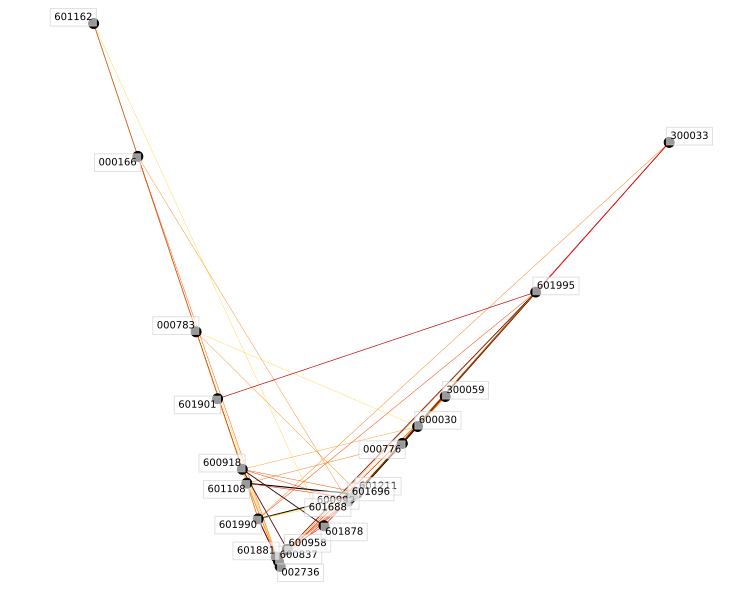

In [182]:
#-*- coding:utf-8 -*-
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 只能对windows使用的显示中文方法
# from matplotlib.font_manager import FontProperties
# font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels

codes = [code_dict[i] for i in names]
for index, (name, label, (x, y)) in enumerate(zip(codes, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()

**Leadlag Network**

- 前面这一段similarity measure的网络可视化代码是sklearn的tut里面学到的, 整体的配置非常棒, 完全可以来画类似影响力网络的东西, 相当于用matplotlib替代掉networkx的工具. 当然本身networkx也是很强大的工具, 知乎上也有使用networkx和gephi制造非常好看的神经网络可视化的工具. 总而言之, 以上图基本可以修改, 然后尝试把无向图改成有向图, 再更改一下线段的模式, 基本上就可以实现lead-lag network了, 无非就是把线段颜色决定的correlation matrix换成一个LLR matrix. 
- 有时间研究下画图代码, 然后把这个搞定了. 

#### **Granger Causality Test**

In [183]:
target_date = '20220615'

In [184]:
# 检查redis是否已经存储了该天的市场数据
df_bytes_from_redis = SERVER.hget("tick_list", target_date)
test_df = pickle.loads(df_bytes_from_redis)
print(test_df)

[server_time
2022-06-15 09:30:00    8.098369
2022-06-15 09:30:03    8.098293
2022-06-15 09:30:06    8.098311
2022-06-15 09:30:09    8.098552
2022-06-15 09:30:12    8.098543
                         ...   
2022-06-15 14:56:46    8.103939
2022-06-15 14:56:48    8.103773
2022-06-15 14:56:51    8.103791
2022-06-15 14:56:54    8.103730
2022-06-15 14:56:57    8.103806
Name: midquote, Length: 4784, dtype: float64, server_time
2022-06-15 09:30:00    2.880882
2022-06-15 09:30:03    2.880882
2022-06-15 09:30:06    2.881443
2022-06-15 09:30:09    2.880602
2022-06-15 09:30:12    2.880041
                         ...   
2022-06-15 14:56:45    2.909357
2022-06-15 14:56:48    2.909357
2022-06-15 14:56:51    2.909357
2022-06-15 14:56:54    2.909357
2022-06-15 14:56:57    2.909357
Name: midquote, Length: 4741, dtype: float64, server_time
2022-06-15 09:30:00    8.018823
2022-06-15 09:30:03    8.018866
2022-06-15 09:30:06    8.018744
2022-06-15 09:30:09    8.019126
2022-06-15 09:30:12    8.018876
       

In [186]:
meg = pd.DataFrame([i.values for i in temp_data], index=name_list).T
# 取一部分做可视化
meg = meg[np.array(meg.columns)[meg.columns.str.contains("证券") | meg.columns.isin(['中金公司', '中信建投', '同花顺', '国泰君安', '中国银河', '东方财富', '申万宏源'])]]
meg = meg.dropna(how='all', axis=1).iloc[:4001]
t = meg.isnull().sum()
t[t > 0]

Series([], dtype: int64)

In [188]:
names = meg.columns
meg_array = meg.to_numpy().T
meg_array.shape

(21, 4001)

In [190]:
def upper_triangular_indeces(p):
    """Get the upper triangular indeces of a square matrix. int16 should
    suffice for even the largest ``p`` encountered in practice.

    Parameters
    ----------
    p : int
        The dimension of the square matrix.

    Returns
    -------
    idx : numpy.ndarray, shape(int((p*(p+1)/2), 2)
        The array of indeces. i in zeroth column, j in first column.
    """
    s = 0
    idx = np.zeros((int((p*(p+1)/2)), 2))
    for i in range(p):
        for j in range(i, p):
            idx[s] = i, j
            s += 1
    if idx[-1, 0] <= 0:
        raise ValueError("Got negative index, ``p`` probably too large for int16")
    return idx

In [203]:
idx1 = 0
idx2 = 1

df_test = meg[[names[idx1], names[idx2]]]

from statsmodels.tsa.stattools import grangercausalitytests
gc_res = grangercausalitytests(df_test, [1])

p_value = gc_res[1][0]['ssr_ftest'][1]
p_value


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0033  , p=0.0455  , df_denom=3997, df_num=1
ssr based chi2 test:   chi2=4.0064  , p=0.0453  , df=1
likelihood ratio test: chi2=4.0043  , p=0.0454  , df=1
parameter F test:         F=4.0033  , p=0.0455  , df_denom=3997, df_num=1


0.045477459520134524

In [208]:
p = meg_array.shape[0]
gc_p_value = np.zeros((p, p))

# don't loop over ranges but get all indeces in advance
# to improve parallelization.

idx = upper_triangular_indeces(p)

for t in range(len(idx)):
# for t in tqdm(prange(len(idx))):
    i, j = idx[t, :]

    df_test = meg[[names[i], names[j]]]
    df_inv_test = meg[[names[j], names[i]]]

    # second column granger causes the first column
    gc_res = grangercausalitytests(df_test, 5)
    # gc_res = grangercausalitytests(df_test, [5])

    gc_res_inv = grangercausalitytests(df_inv_test, 5)

    # only pick the first granger lag term
    gc_p_value[i, j] = gc_res[1][0]['ssr_ftest'][1]
    gc_p_value[j, i] = gc_res_inv[1][0]['ssr_ftest'][1]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=3998, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=1951059.9748, p=0.0000  , df_denom=3998, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=3996, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=1006220.7143, p=0.0000  , df_denom=3996, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=-1313.7815, p=1.0000  , df_denom=3994, df_num=3
ssr based chi2 test:   chi2=-3945.2917, p=1.0000  , df=3
likelihood ratio test: chi2=-17306.4453, p=1.0000  , df=3
parameter F test:         F=0.0059  , p=0.9941  , df_denom=3994, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F

In [209]:
gc_p_df = pd.DataFrame(gc_p_value, columns=names, index=names)
gc_p_df.head()

,申万宏源,广发证券,长江证券,国信证券,同花顺,东方财富,中信证券,海通证券,中泰证券,东方证券,招商证券,财通证券,天风证券,国泰君安,华泰证券,中银证券,浙商证券,中国银河,方正证券,南京证券,中金公司
申万宏源,1.000000e+00,0.045477,6.392826e-18,7.256851e-14,0.001828,2.841707e-08,5.842978e-04,7.439269e-21,1.121297e-22,1.191738e-08,8.755950e-05,1.030820e-09,1.202507e-14,1.122467e-21,1.570230e-11,2.282495e-06,9.266273e-03,1.072402e-10,5.201367e-09,7.702470e-03,0.000002
广发证券,1.889865e-11,0.999996,9.264662e-09,5.440839e-09,0.181040,4.206594e-13,1.878517e-08,9.096626e-13,1.069513e-14,1.275233e-13,9.608582e-09,1.915942e-09,3.520228e-15,4.892213e-14,2.902325e-15,5.156326e-08,4.698422e-11,1.870326e-11,1.253727e-09,1.354121e-12,0.000004
长江证券,9.588266e-22,0.379946,9.999962e-01,2.693768e-14,0.008073,5.938544e-08,3.421556e-02,1.269475e-14,3.064865e-18,3.582859e-09,5.467456e-06,1.318752e-09,1.497669e-09,1.035821e-15,9.221698e-12,7.690283e-08,4.635294e-02,3.516852e-11,3.199875e-07,2.073374e-02,0.000002
国信证券,7.935926e-04,0.808753,2.433542e-03,9.999970e-01,0.035012,5.440699e-03,7.779125e-01,4.317908e-05,6.568337e-07,5.040406e-03,9.470056e-03,3.197254e-03,6.044245e-04,1.877564e-04,1.407405e-03,1.121932e-02,4.508966e-01,4.864721e-03,4.540954e-02,4.195467e-01,0.041521
同花顺,1.061005e-17,0.001683,3.274800e-13,5.264957e-07,0.999995,4.080435e-09,6.467205e-04,3.870852e-11,4.476392e-17,5.500417e-13,1.149017e-09,5.218167e-12,4.296320e-13,4.099617e-13,4.629183e-13,6.893823e-10,1.640543e-06,3.731269e-11,4.488824e-09,2.786455e-05,0.000003


In [216]:
gc_p_df['广发证券'][gc_p_df['广发证券'] > 0.05]

广发证券    0.999996
长江证券    0.379946
国信证券    0.808753
中信证券    0.052495
海通证券    0.875921
中泰证券    0.985970
东方证券    0.510239
招商证券    0.612456
财通证券    0.838617
国泰君安    0.895320
华泰证券    0.864578
中银证券    0.527018
浙商证券    0.134015
中国银河    0.205272
南京证券    0.424944
中金公司    0.319197
Name: 广发证券, dtype: float64

In [218]:
gc_p_df['广发证券'][gc_p_df['广发证券'] < 0.05]

申万宏源    0.045477
同花顺      0.001683
东方财富    0.008561
天风证券    0.036405
方正证券    0.021724
Name: 广发证券, dtype: float64

In [214]:
gc_p_df.T['广发证券'][gc_p_df.T['广发证券'] > 0.05]

广发证券    0.999996
同花顺      0.181040
Name: 广发证券, dtype: float64

In [217]:
gc_p_df.T['广发证券'][gc_p_df.T['广发证券'] < 0.05]

申万宏源    1.889865e-11
长江证券    9.264662e-09
国信证券    5.440839e-09
东方财富    4.206594e-13
中信证券    1.878517e-08
海通证券    9.096626e-13
中泰证券    1.069513e-14
东方证券    1.275233e-13
招商证券    9.608582e-09
财通证券    1.915942e-09
天风证券    3.520228e-15
国泰君安    4.892213e-14
华泰证券    2.902325e-15
中银证券    5.156326e-08
浙商证券    4.698422e-11
中国银河    1.870326e-11
方正证券    1.253727e-09
南京证券    1.354121e-12
中金公司    4.064941e-06
Name: 广发证券, dtype: float64

A brief conclusion
- 以上的similarity measure和granger检验都只是进行粗浅的对齐匹配之后随便算的一个,严谨的还是需要使用previous tick类似的根据固定时间grid进行的merge_asof匹配填充或者指数平滑去做对齐,然后再去做cluster,或者计算previous-tick的pairwise corr matrix,去对齐之后做格兰杰因果检验.不过对齐后运算方法和上面基本一样,granger也可以取不同lag的p值看结果,整体证券板块互相之间应该是存在预测作用的.
- 以上的数据为了去除掉涨跌停的影响,只取了一天的数据做cluster以及算因果检验,所以可能会出现一些同一板块的股票不在一个cluster的情况.
- 在我现在看来cluster和一些常见的similarity measure仅仅是初步的一些分析,如果数据的时间线长一些或者使用的日线数据,那么基本上cluster是能反应很多有意思的信息.对于correlation matrix的衡量现在有太多的手段,比如线性系数/HY系数矩阵/对高斯序列用的图lasso等拟合技术/dynamic time warping等各种方法.正好有affinity propagation这种方法可以测试这些correlation matrix的准确性.当然,这么多的方法衡量两个时序的相关性,很有用,能给我们关于原始时间序列的基本认知,但是都仅限于原序列.我们的最终目的是预测,这些工具只能近似告诉我们原始序列或者说偏宏观上的相关性.所以HY相关系数或者lasso regression的作用仍然是无法替代的.当然在用这两种工具做leadlag的预测的时候,提前使用granger因果检验是必要的,granger也是基于原始序列,并且不能给我们有关预测的帮助,但是granger能告诉我们究竟能不能用X来预测Y.如果可以,如果能,那我们再去用lasso回归,再去用HY相关系数做预测.毕竟本身HY系数大小和LLR这种东西不能告诉我们序列X对Y的预测效果究竟是怎样,因为缺乏一个严谨的statistical test.而这就是granger test的意义所在.